In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd
from sklearn  import preprocessing
from collections import defaultdict, Counter
# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [5]:
def downsample_spectrogram(X, N):
    
    time_splits = np.array_split(X, N, axis=1)
    pooled_splits = [np.mean(split, axis=1) for split in time_splits] 
    v = np.concatenate(pooled_splits)
    return v

In [6]:
data = pd.read_csv('SDR_metadata.tsv', sep='\t')
train_data = data[data.split =="TRAIN"]

In [7]:
print(set(train_data.split.values))
print(train_data.head())

{'TRAIN'}
   Unnamed: 0    identifier  speaker  split  label  \
0           0     5_theo_23     theo  TRAIN      5   
6           6   4_george_11   george  TRAIN      4   
7           7   8_george_18   george  TRAIN      8   
8           8   8_george_13   george  TRAIN      8   
9           9  2_nicolas_16  nicolas  TRAIN      2   

                           file  
0     speech_data/5_theo_23.wav  
6   speech_data/4_george_11.wav  
7   speech_data/8_george_18.wav  
8   speech_data/8_george_13.wav  
9  speech_data/2_nicolas_16.wav  


In [8]:
def get_downsampled_data(df):
    signals = df.file.values
    labels = df.label.values
    # This value details is given in TASK 1 parameter N <= 25
    N=10   

    signals1 = []
    for file in df.file.values:
        signal1, sr = librosa.load(file)
        signals1.append(signal1)

    return [downsample_spectrogram(extract_melspectrogram(s, sr=8000, num_mels=13), N) for s in signals1], labels


In [9]:
# prepare data 
data = pd.read_csv('SDR_metadata.tsv', sep='\t')

train_data = data[data.split =="TRAIN"]
dev_data = data[data.split =="DEV"]
test_data = data[data.split =="TEST"]

downsampled_train, train_labels = get_downsampled_data(train_data)
downsampled_dev, dev_labels = get_downsampled_data(dev_data)
downsampled_test, test_labels= get_downsampled_data(test_data)

In [10]:
##MLP Classifier with SGD training
##The loss function as ‘perceptron’ is the linear loss used by the perceptron algorithm

from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)

clf.fit(downsampled_train, train_labels)

SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', penalty=None)

In [11]:
accuracy = clf.score(downsampled_train, train_labels)
print("Accuracy on train set: ", accuracy)

accuracy = clf.score(downsampled_dev, dev_labels)
print("Accuracy on dev set: ", accuracy)

accuracy = clf.score(downsampled_test, test_labels)
print("Accuracy on test set: ", accuracy)

Accuracy on train set:  0.862
Accuracy on dev set:  0.4084507042253521
Accuracy on test set:  0.4274353876739563


In [12]:
from sklearn.metrics import accuracy_score

dev_predictions = clf.predict(downsampled_dev)
dev_accuracy = accuracy_score(dev_labels, dev_predictions)
print("Accuracy on development set: ", dev_accuracy)

test_predictions = clf.predict(downsampled_test)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on test set: ", test_accuracy)

Accuracy on development set:  0.4084507042253521
Accuracy on test set:  0.4274353876739563


Confusion matrix on development set: 



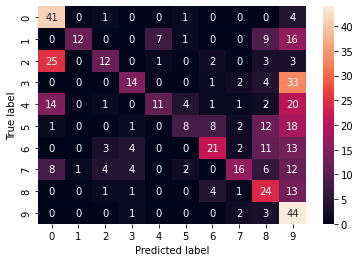

Confusion matrix on test set: 



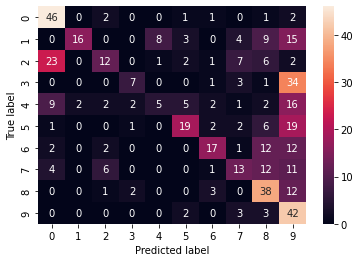

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

dev_confusion_matrix = confusion_matrix(dev_labels, dev_predictions)
print("Confusion matrix on development set: \n")
cm = confusion_matrix(dev_labels, dev_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


test_confusion_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion matrix on test set: \n")
cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [14]:
from sklearn.metrics import classification_report

dev_classification_report = classification_report(dev_labels, dev_predictions)
print("Classification report on development set: \n", dev_classification_report)

test_classification_report = classification_report(test_labels, test_predictions)
print("Classification report on test set: \n", test_classification_report)


Classification report on development set: 
               precision    recall  f1-score   support

           0       0.46      0.87      0.60        47
           1       0.92      0.27      0.41        45
           2       0.55      0.26      0.35        46
           3       0.56      0.26      0.35        54
           4       0.58      0.20      0.30        54
           5       0.50      0.16      0.24        50
           6       0.57      0.39      0.46        54
           7       0.62      0.30      0.41        53
           8       0.32      0.55      0.41        44
           9       0.25      0.88      0.39        50

    accuracy                           0.41       497
   macro avg       0.53      0.41      0.39       497
weighted avg       0.53      0.41      0.39       497

Classification report on test set: 
               precision    recall  f1-score   support

           0       0.54      0.87      0.67        53
           1       0.89      0.29      0.44        